# Building a Recommender System Instacart Users
## This project build a product recommendation system using implicit user activity
Products are recommended based on the number of number times an item has been reordered

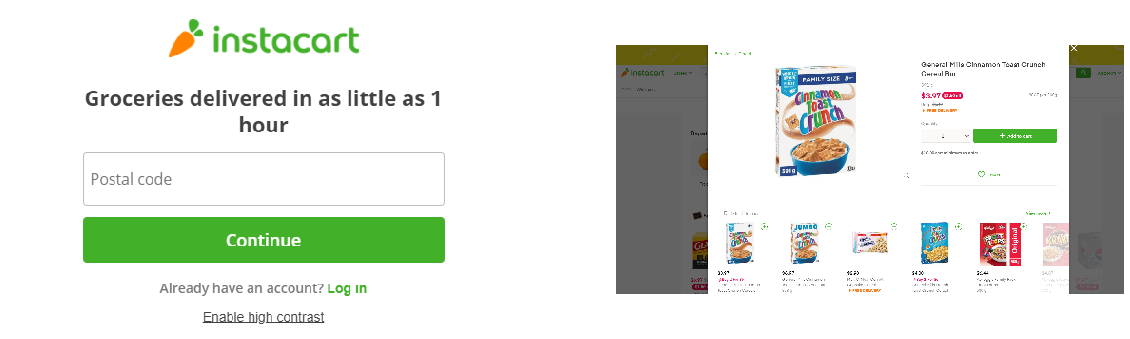

In [1]:
# importing matplotlib modules 
import matplotlib
%matplotlib inline
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (20,15)
img_1 = mpimg.imread('Instacart2.png') 
img_2 = mpimg.imread('Instacart1.png')  
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [2]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
matplotlib.use('nbagg')

plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import implicit
import random

In [3]:
# Loading data
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

In [4]:
print(len(order_products_prior))
order_products_prior.head()

32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
print(len(orders))
orders.head()

3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
print(len(products))
products.head()

49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
orders_prior = orders[orders.eval_set=="prior"]       # main dataset
print(len(orders_prior))
orders_prior.head(10)

3214874


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [8]:
orders_prior = orders_prior.iloc[:, 0:4]
orders_prior.head()

,order_id,user_id,eval_set,order_number
0,2539329,1,prior,1
1,2398795,1,prior,2
2,473747,1,prior,3
3,2254736,1,prior,4
4,431534,1,prior,5


In [9]:
order_products_prior = order_products_prior.iloc[:, :]    # has order ID
len(order_products_prior)
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
orders_all = pd.merge(orders_prior, order_products_prior, how = 'left', on = 'order_id')
orders_all.head()

,order_id,user_id,eval_set,order_number,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,196,1,0
1,2539329,1,prior,1,14084,2,0
2,2539329,1,prior,1,12427,3,0
3,2539329,1,prior,1,26088,4,0
4,2539329,1,prior,1,26405,5,0


In [11]:
# product = products.iloc[:, 0:2]
product = products
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [12]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [13]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [14]:
orders_all_product = pd.merge(orders_all, product, how = 'left', on = 'product_id')
orders_all_product.head()

,order_id,user_id,eval_set,order_number,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,prior,1,196,1,0,Soda,77,7
1,2539329,1,prior,1,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,prior,1,12427,3,0,Original Beef Jerky,23,19
3,2539329,1,prior,1,26088,4,0,Aged White Cheddar Popcorn,23,19
4,2539329,1,prior,1,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17


In [16]:
product_aisle = pd.merge(product, aisles, how = 'left', on = 'aisle_id')
product_aisle_dept = pd.merge(product_aisle, departments, how = 'left', on = 'department_id')
product_aisle_dept.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [17]:
orders_all_product_aisle_dept = pd.merge(orders_all, product_aisle_dept, how = 'left', on = 'product_id')
orders_all_product_aisle_dept.head()

,order_id,user_id,eval_set,order_number,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
2,2539329,1,prior,1,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks
3,2539329,1,prior,1,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
4,2539329,1,prior,1,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household


In [20]:
grouped = pd.DataFrame(orders_all_product_aisle_dept.groupby(['user_id', 'product_id','product_name', 
                                                  'aisle', 'department'])['reordered'].count())
grouped = grouped.reset_index()
grouped.to_csv('grouped_table.csv')

In [21]:
grouped.head()

,user_id,product_id,product_name,aisle,department,reordered
0,1,196,Soda,soft drinks,beverages,10
1,1,10258,Pistachios,nuts seeds dried fruit,snacks,9
2,1,10326,Organic Fuji Apples,fresh fruits,produce,1
3,1,12427,Original Beef Jerky,popcorn jerky,snacks,10
4,1,13032,Cinnamon Toast Crunch,cereal,breakfast,3


In [19]:
train = grouped[grouped['reordered'] >= 1]
train.head()

,user_id,product_id,product_name,aisle,department,reordered
0,1,196,Soda,soft drinks,beverages,10
1,1,10258,Pistachios,nuts seeds dried fruit,snacks,9
2,1,10326,Organic Fuji Apples,fresh fruits,produce,1
3,1,12427,Original Beef Jerky,popcorn jerky,snacks,10
4,1,13032,Cinnamon Toast Crunch,cereal,breakfast,3


In [20]:
train.to_csv('greater_than_1.csv')

## Exploratory Data Analysis

### Re-ordered Products Percentage

In [154]:
orders_all_product_aisle_dept.reordered.sum() / orders_all_product_aisle_dept.shape[0]

0.5896974667922161

About 59% of the products in the orders were ordered before.

### Percentage of orders without re-ordered items

In [158]:
grouped_order_id = orders_all_product_aisle_dept.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_order_id["reordered"].loc[grouped_order_id["reordered"]>=1] = 1
grouped_order_id.reordered.value_counts() / grouped_order_id.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

12% of the orders do not have re-ordered items

### Distribution of Products Bought Per Order

<IPython.core.display.Javascript object>


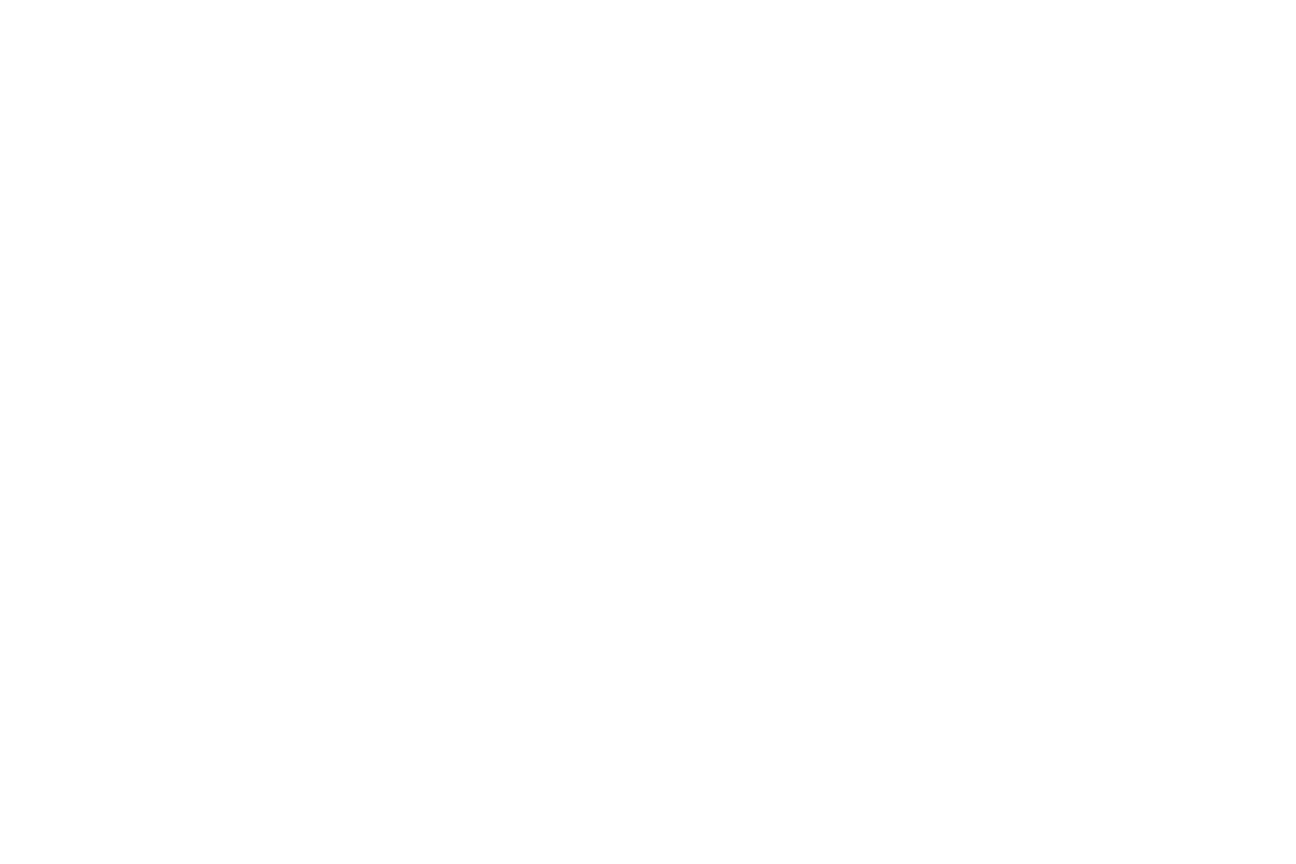

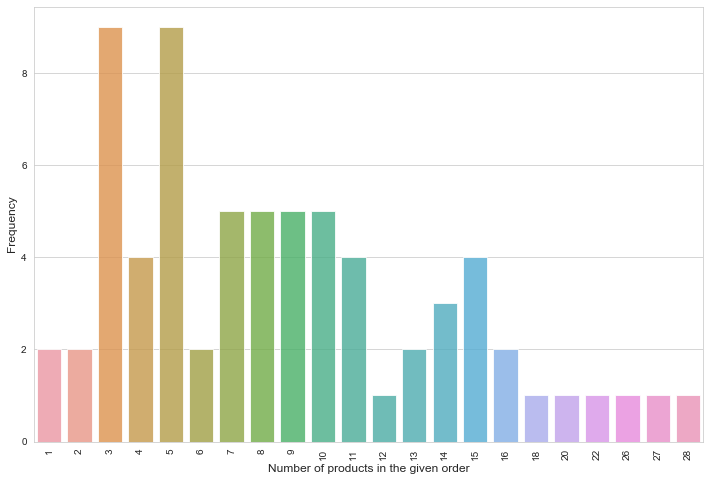

In [23]:
grouped_add_2_cart = orders_all_product_aisle_dept.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index().head(70)
count = grouped_add_2_cart.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Popular Products

In [125]:
product_data = train['product_name'].value_counts().reset_index()
product_data.columns = ['product_name', 'frequency']
product_data.head()

,product_name,frequency
0,Banana,73956
1,Bag of Organic Bananas,63537
2,Organic Strawberries,58838
3,Organic Baby Spinach,55037
4,Large Lemon,46402


Most of the products are organic products (fruits and veggies).

### Common Aisles

<IPython.core.display.Javascript object>


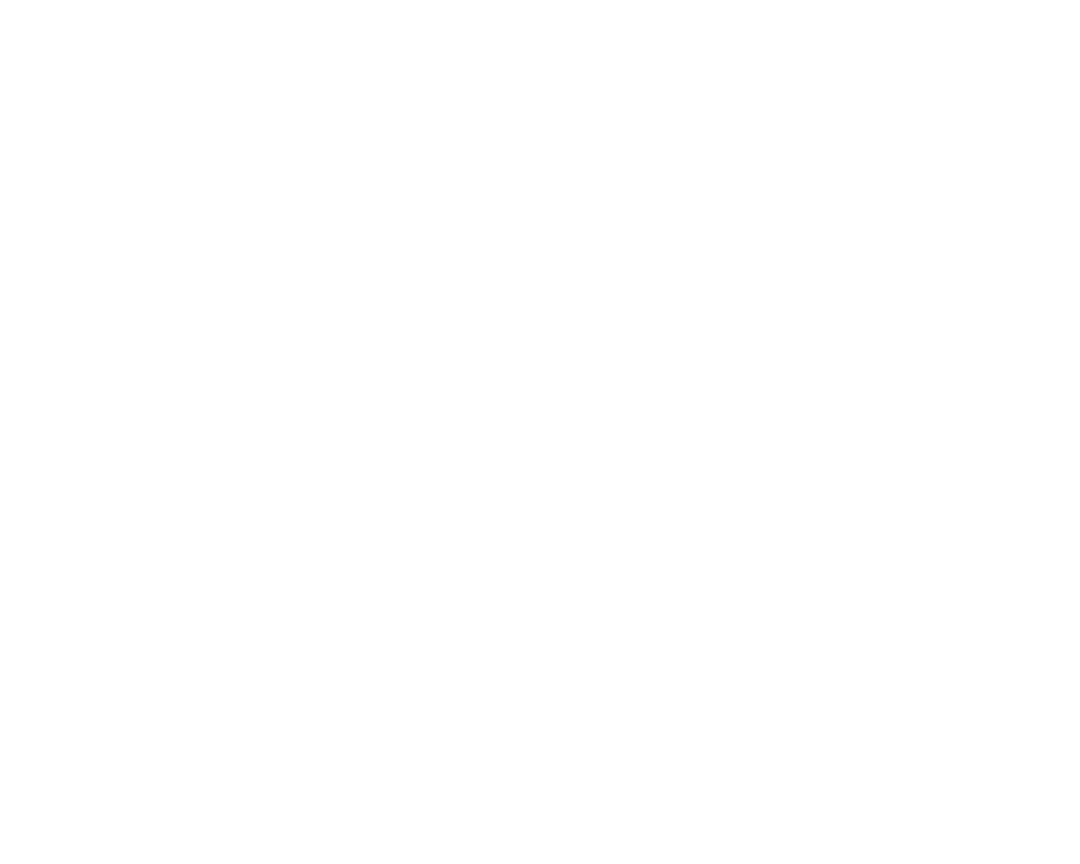

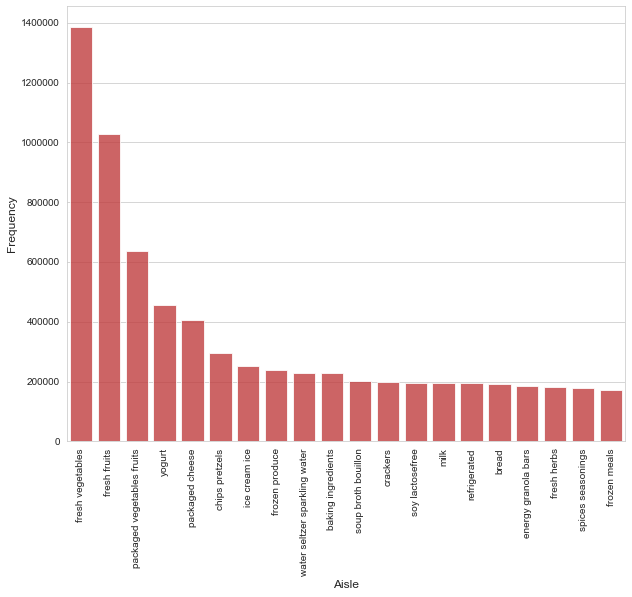

In [153]:
aisle_data_top_20 = train['aisle'].value_counts().reset_index().head(20)
aisle_data_top_20.columns = ['aisle', 'frequency']

# plot bar chart
plt.rcParams["figure.figsize"] = (10,8)
color = sns.color_palette()
sns.barplot(aisle_data_top_20.aisle, aisle_data_top_20.frequency, alpha=0.8, color=color[3])
plt.xlabel('Aisle', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The two most common aisles are fresh vegetables and fresh fruits.

### Distribution of Deparments

<IPython.core.display.Javascript object>


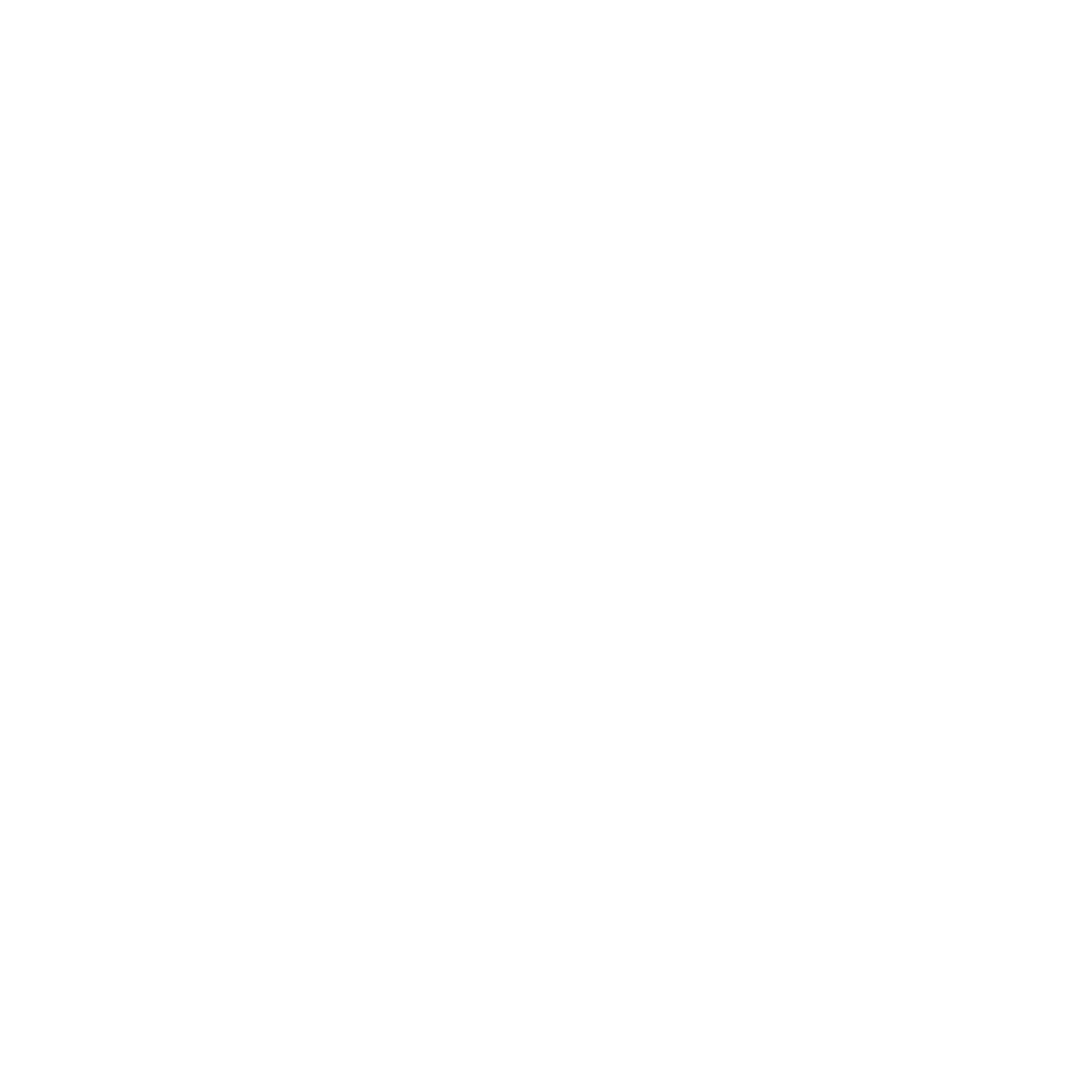

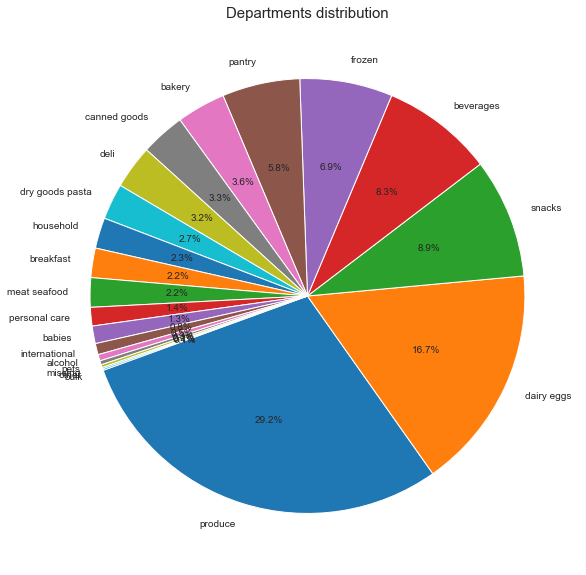

In [24]:
plt.figure(figsize=(10,10))
department_count = orders_all_product_aisle_dept['department'].value_counts()
labels = (np.array(department_count.index))
sizes = (np.array((department_count / department_count.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

The largest department is Produce

### Building a recommender system for customers of instacart with purchases >= 1

In [152]:
# Load train dataset
train = train.rename(columns={"reordered":"quantity"})
train.head()

,user_id,product_id,product_name,aisle,department,quantity
0,1,196,Soda,soft drinks,beverages,10
1,1,10258,Pistachios,nuts seeds dried fruit,snacks,9
2,1,10326,Organic Fuji Apples,fresh fruits,produce,1
3,1,12427,Original Beef Jerky,popcorn jerky,snacks,10
4,1,13032,Cinnamon Toast Crunch,cereal,breakfast,3


In [22]:
start = datetime.now()
users = list(np.sort(train.user_id.unique())) # Get our unique users
products = list(train.product_id.unique()) # Get our unique products that were purchased
quantities = list(train.quantity) # All of our purchases

# Get the associated row indices
rows = train.user_id.astype('category', categories = users).cat.codes 
# Get the associated column indices
cols = train.product_id.astype('category', categories = products).cat.codes 

# Creating the sparse matrix
train_sparse = sparse.csr_matrix((quantities, (rows, cols)), shape=(len(users), len(products)))

print(datetime.now() - start)

C:\Users\hunyi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


0:00:04.950731


In [23]:
# Let’s check our final matrix object:
train_sparse

<206209x49677 sparse matrix of type '<class 'numpy.int32'>'
	with 13307953 stored elements in Compressed Sparse Row format>

We have *206,209* users with *49,677* products. For these user/product interactions, *13,307,953* of these product had a purchase.

In [24]:
# The Sparsity of Train Sparse Matrix
us,pd = train_sparse.shape
elem = train_sparse.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*pd))) * 100) )

Sparsity Of Train matrix : 99.8700882953749 % 


## Function that Creates test set from train set
We are going to mask 20% of our training set. The test set will be binaralized as zeros and ones. We then see how well our model is doing by comparing the masked values in our training set.

In [25]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy()                  # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1                # Store the test set as a binary preference matrix
    training_set = ratings.copy()              # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero()      # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0)                             # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples)     # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples]             # Get the user row indices
    item_inds = [index[1] for index in samples]             # Get the item column indices
    training_set[user_inds, item_inds] = 0                  # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros()                          # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds))     # Output the unique list of user rows that were altered  

## Train_Test_Split
masking 20% of the data 

In [26]:
product_train, product_test, product_users_altered = make_train(train_sparse, pct_test = 0.2)
product_train

<206209x49677 sparse matrix of type '<class 'numpy.int32'>'
	with 10646362 stored elements in Compressed Sparse Row format>

## Implementing ALS for Implicit Feedback utilizing Cython

In [107]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

100%|████████████████████████████████████████████████████████████████████████████████| 50.0/50 [03:06<00:00,  3.28s/it]


## Evaluating the Recommender System
We will evaluate the recommender system with Receiver operating Characteristic Curve(ROC). A greater area under the curve(AUC) means we are recommending items that end up being purchased near the top of the list of recommended items. Usually this metric is used in more typical binary classification problems to identify how well a model can predict a positive example vs. a negative one. It will also work well for our purposes of ranking recommendations.

In [28]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

using the function above as a helper function in calculating the mean area under the curve for all users masked in our training data. The mean_auc function compares the area under the curve for our recommendation model and also based on using popularity as a recommendation

In [29]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

We can now use this function to see how our recommender system is doing. To use this function, we will need to transform our output from the ALS function to csr_matrix format and transpose the item vectors. The original pure Python version output the user and item vectors into the correct format already.

In [30]:
# AUC for our recommender system
calc_mean_auc(product_train, product_users_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)

(0.946, 0.921)

We can see that our recommender system beat popularity. Our system had a mean AUC of 0.946, while the popular item benchmark had a lower AUC of 0.921.

In [106]:
predictions[1]

<20x49677 sparse matrix of type '<class 'numpy.float32'>'
	with 992480 stored elements in Compressed Sparse Row format>

### ROC Plot

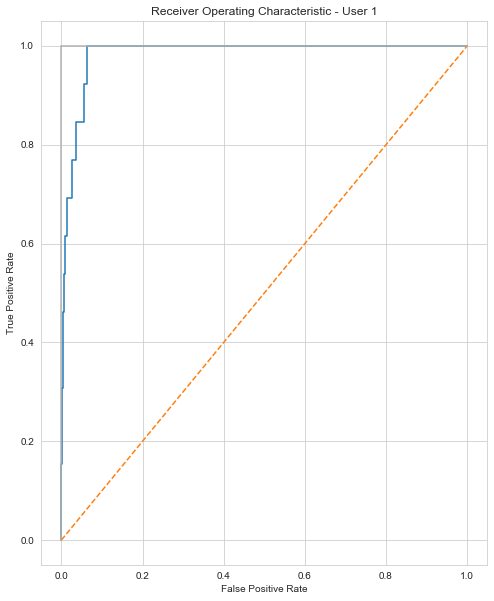

In [108]:
predictions = [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)]
user = product_users_altered[1]
item = predictions[1]
user_vec_ = predictions[0][user,:]
training_row = product_train[user,:].toarray().reshape(-1)

zero_indx = np.where(training_row == 0)
pred = user_vec_.dot(item).toarray()[0,zero_indx].reshape(-1)
actual = product_test[user,:].toarray()[0,zero_indx].reshape(-1)

fpr, tpr, thresholds = metrics.roc_curve(actual, pred)

# Ploting ROC curves
plt.title('Receiver Operating Characteristic - User 1')
plt.rcParams["figure.figsize"] = (8,10)
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###  Example
We now have our recommender system trained and have proven it beats the benchmark of popularity. An AUC of 0.946 means the system is recommending products the user in fact had purchased in the test set far more frequently than products the user never ended up purchasing. To see an example of how it works, let’s examine the recommendations given to a particular user and decide subjectively if they make any sense.

First, however, we need to find a way of retrieving the products already purchased by a user in the training set. Initially, we will create an array of our users and products we made earlier.

In [31]:
users_arr = np.array(users)          # Array of users IDs from the ratings matrix
products_arr = np.array(products)    # Array of product IDs from the ratings matrix

In [32]:
len(train.department)

13307953

In [35]:
product_name_list = list(train.product_name.unique())
d = {'product_id':products,'product_name':product_name_list}
description = pd.DataFrame(d)
description.head()

# product_name_list = list(train.product_name.unique())
# aisle_name_list = list(train.aisle.unique())
# department_name_list = list(train.department.unique())
# d = {'product_id':products,'product_name':product_name_list,'aisle':aisle_name_list,
#     'department':department_name_list}
# description = pd.DataFrame(d)
# description.head()

,product_id,product_name
0,196,Soda
1,10258,Pistachios
2,10326,Organic Fuji Apples
3,12427,Original Beef Jerky
4,13032,Cinnamon Toast Crunch


Now, we can create a function that will return a list of the products name from our product table

In [36]:
def get_items_purchased(user_id, train_matrix, users_list, products_list, product_description):
    '''
    This just tells me which items have been already purchased by a specific user in the training set. 
    
    parameters: 
    
    user_id - Input the customer's id number that you want to see prior purchases of at least once
    
    train_matrix - The training matrix used for matrix factorization fitting
    
    users_list - The array of customers used in the ratings matrix
    
    products_list - The array of products used in the ratings matrix
    
    product_description - A dataframe containning the unique product_id with their names
    
    returns:
    
    A list of item IDs and item descriptions for a particular customer that were already purchased in the training set
    '''
    cust_ind = np.where(users_list == user_id)[0][0]         # Returns the index row of our customer id
    purchased_ind = train_matrix[cust_ind,:].nonzero()[1]    # Get column indices of purchased items
    prod_codes = products_list[purchased_ind]                # Get the stock codes for our purchased items
    return product_description.loc[product_description.product_id.isin(prod_codes)]

In [114]:
# We need to look these up by a User ID. Looking at the list of customers:
users_arr[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

We can see that we have an array of user_id where the first user listed has an user_id of 1. Let’s examine user_id = 6 purchases from the training set.

In [103]:
get_items_purchased(6, product_train, users_arr, products_arr, description) # You can experiment by changing the user_id

,product_id,product_name
132,21903,Organic Baby Spinach
186,8424,Broccoli Crown
189,20323,Strained Tomatoes
190,25659,Organic Coconut Milk
191,27521,Organic Lacinato (Dinosaur) Kale
192,38293,Ground Turkey Breast
193,40992,Chopped Tomatoes
194,45007,Organic Zucchini
195,48679,Organic Garnet Sweet Potato (Yam)


In [109]:
def recommended_products(user_id, train_matrix, user_vecs, product_vecs, user_list, product_list, product_description, num_items = 5):
    '''
    This function will return the top recommended products to our users 
    
    parameters:
    
    user_id - Input the customer's id number that you want to get recommendations for
    
    train_matrix - The training matrix used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_product - the item vectors from your fitted matrix factorization
    
    user_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    product_list - an array of the products that make up the columns of your ratings matrix
                    (in order of matrix)
    
    product_description - A simple pandas dataframe of the unique product ID/product descriptions available
    
    num_items - The number of items you want to recommend in order of best recommendations. Default is 5. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    cust_ind = np.where(user_list == user_id)[0][0] # Returns the index row of our customer id
    pref_vec = train_matrix[cust_ind,:].toarray()   # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1             # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0                      # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(product_vecs.T) # Get dot product of user vector and all item vectors
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order of best recommendations
    rec_list = []                                                # start empty list to store items
    for index in product_idx:
        code = product_list[index]
        rec_list.append([code, product_description.product_name.loc[product_description.product_id == code].iloc[0]]) 
        
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]

    return product_description.loc[product_description.product_id.isin(codes)]

Essentially, this will retrieve the N highest ranking dot products between our user and products vectors for a particular user. products already purchased are not recommended to the user. For now, let’s use a default of 5 products and see what the recommender system decides to pick for our customer.

In [110]:
purchased = get_items_purchased(97567, product_train, users_arr, products_arr, description)
purchased

,product_id,product_name
143,42265,Organic Baby Carrots
182,31717,Organic Cilantro
258,2078,Unsalted Pure Irish Butter
352,15290,Orange Bell Pepper
366,25931,Organic Baby Spinach Salad
451,5876,Organic Lemon
3141,30720,Sugar Snap Peas
3186,22947,Lactose Free Blueberry Pomegranate Acai Kefir
3335,9515,Natural Classic Pork Breakfast Sausage
5192,38313,Organic Apple Banana GoGo Squeez


In [113]:
recommend = recommended_products(97567, product_train, user_vecs, item_vecs, users_arr, products_arr, description, num_items = 10)
recommend

,product_id,product_name
108,47209,Organic Hass Avocado
111,47766,Organic Avocado
167,8518,Organic Red Onion
194,45007,Organic Zucchini
226,26209,Limes
391,46979,Asparagus
395,47626,Large Lemon
468,22935,Organic Yellow Onion
1014,24964,Organic Garlic
1284,4605,Yellow Onions
